In [97]:
import pandas as pd
#导入数据
train=pd.read_csv('./train.csv')
#查看数据样式
print(train.head)

<bound method NDFrame.head of           ID          Datetime  Count
0          0  25-08-2012 00:00      8
1          1  25-08-2012 01:00      2
2          2  25-08-2012 02:00      6
3          3  25-08-2012 03:00      2
4          4  25-08-2012 04:00      2
...      ...               ...    ...
18283  18283  25-09-2014 19:00    868
18284  18284  25-09-2014 20:00    732
18285  18285  25-09-2014 21:00    702
18286  18286  25-09-2014 22:00    580
18287  18287  25-09-2014 23:00    534

[18288 rows x 3 columns]>


In [98]:
#转换为pandas的日期格式：
train['Datetime']=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
#添加索引列
train.index=train.Datetime
print(train.head())

                     ID            Datetime  Count
Datetime                                          
2012-08-25 00:00:00   0 2012-08-25 00:00:00      8
2012-08-25 01:00:00   1 2012-08-25 01:00:00      2
2012-08-25 02:00:00   2 2012-08-25 02:00:00      6
2012-08-25 03:00:00   3 2012-08-25 03:00:00      2
2012-08-25 04:00:00   4 2012-08-25 04:00:00      2


In [99]:
#删除多余的列
train.drop(['ID','Datetime'],axis=1,inplace=True)
print(train.head())

                     Count
Datetime                  
2012-08-25 00:00:00      8
2012-08-25 01:00:00      2
2012-08-25 02:00:00      6
2012-08-25 03:00:00      2
2012-08-25 04:00:00      2


In [100]:
#按照天来采样
daily_train=train.resample('D').sum()
print(daily_train.head())
daily_train['ds']=daily_train.index
#默认prophet的主要数据是Y，代表分析的数值， ds 单标日期
daily_train.rename(columns={'Count':'y'}, inplace = True)
print(daily_train.head())


            Count
Datetime         
2012-08-25     76
2012-08-26     88
2012-08-27     62
2012-08-28     58
2012-08-29     60
             y         ds
Datetime                 
2012-08-25  76 2012-08-25
2012-08-26  88 2012-08-26
2012-08-27  62 2012-08-27
2012-08-28  58 2012-08-28
2012-08-29  60 2012-08-29


In [101]:
#导入库
from fbprophet import Prophet
#拟合Prophetmodel
m=Prophet(yearly_seasonality=True,daily_seasonality=True ,seasonality_prior_scale=0.1)
m.fit(daily_train)
#预测未来7个月，213天，延长日期到未来天数
future=m.make_future_dataframe(periods=213)
forecast=m.predict(future)
print(forecast)


            ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2012-08-25   -421.986589  -2330.783611     74.059641   -421.986589   
1   2012-08-26   -413.943795  -2491.143070    -96.614128   -413.943795   
2   2012-08-27   -405.901000   -794.052471   1578.163706   -405.901000   
3   2012-08-28   -397.858206   -659.199082   1613.163290   -397.858206   
4   2012-08-29   -389.815411   -735.898697   1535.151927   -389.815411   
..         ...           ...           ...           ...           ...   
970 2015-04-22  16503.607452  15214.905711  17801.644719  16068.046388   
971 2015-04-23  16531.133895  14971.003217  17571.710541  16093.210951   
972 2015-04-24  16558.660338  14828.673253  17409.192635  16116.057231   
973 2015-04-25  16586.186782  13694.281215  16299.542363  16137.792077   
974 2015-04-26  16613.713225  13450.407593  16065.782235  16158.987368   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     -421.986589     -674.772

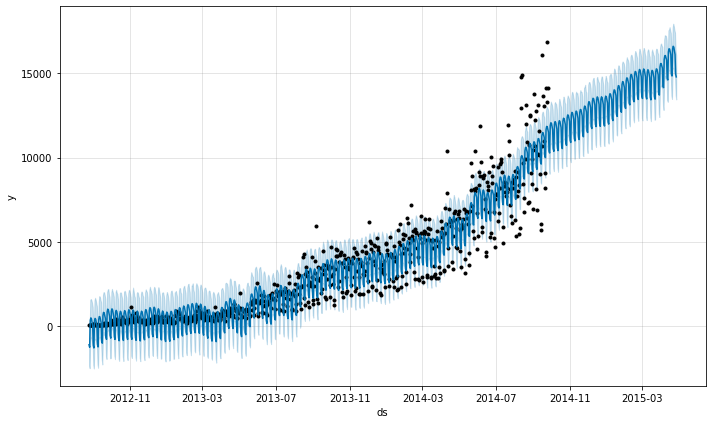

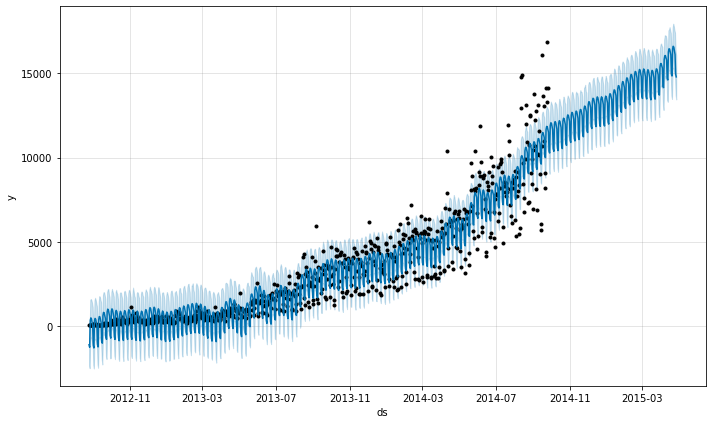

In [102]:
m.plot(forecast)

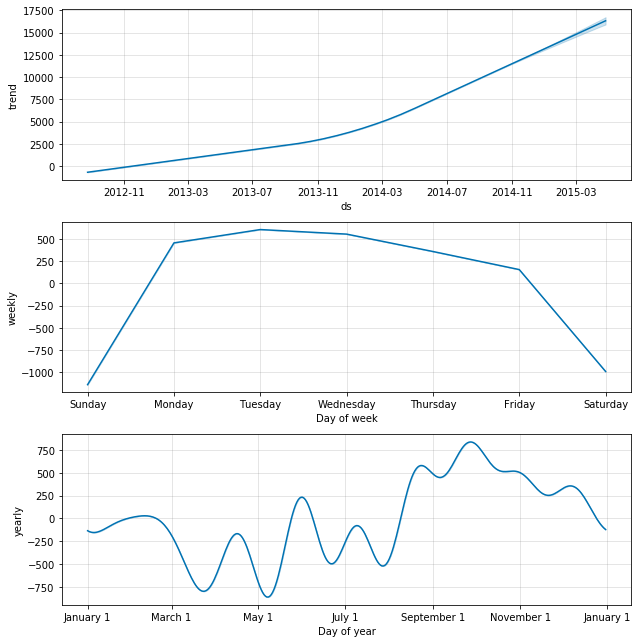

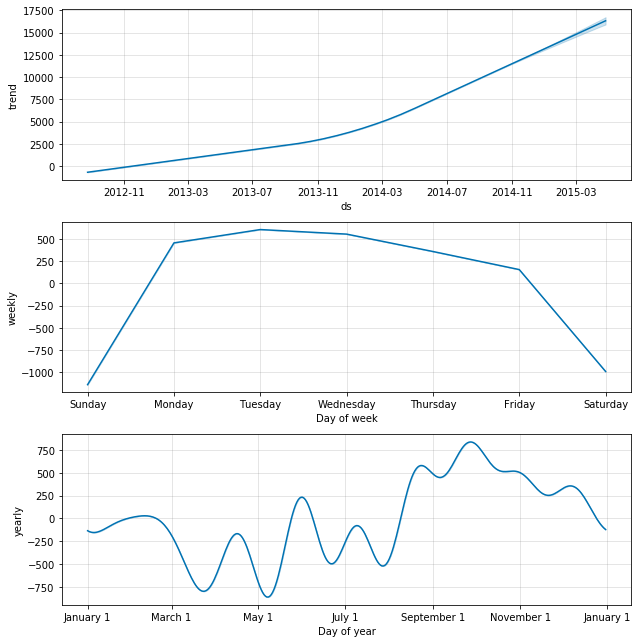

In [22]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
m.plot_components(forecast)

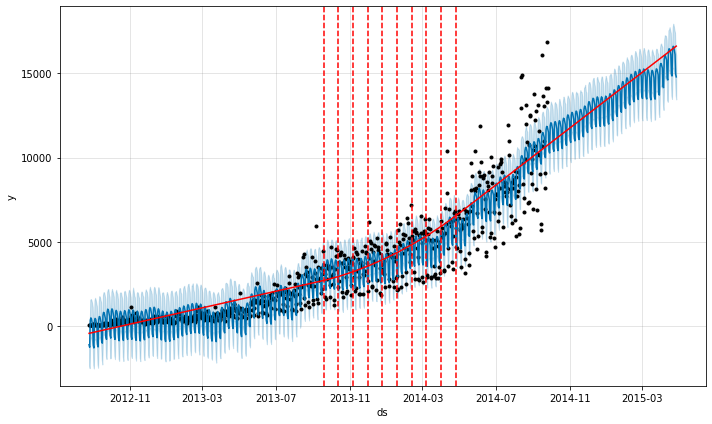

In [104]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
# plt.gca()获得当前的Axes对象ax
# 查看显著的突变点
a = add_changepoints_to_plot(fig.gca(), m, forecast)
print(m)

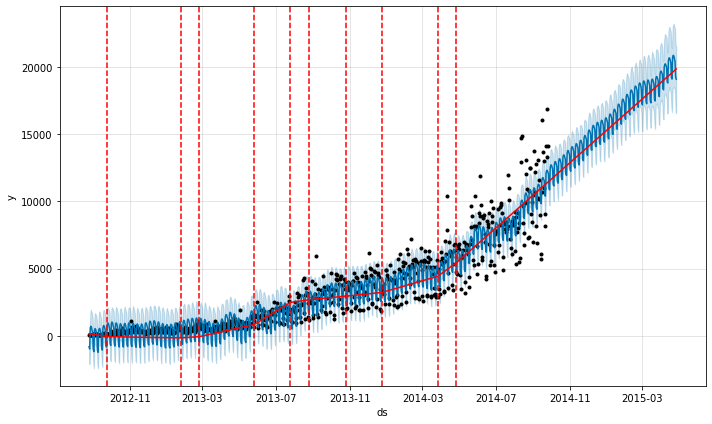

In [122]:
#通过设置突变点的数量，范围，趋势强度，来改变突变点洞察
#changepoint_prior_scale 趋势强度
#n_changepoints数量
#changepoint_range范围
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, daily_seasonality=True,changepoint_prior_scale=0.8)
forecast = pro_change.fit(daily_train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

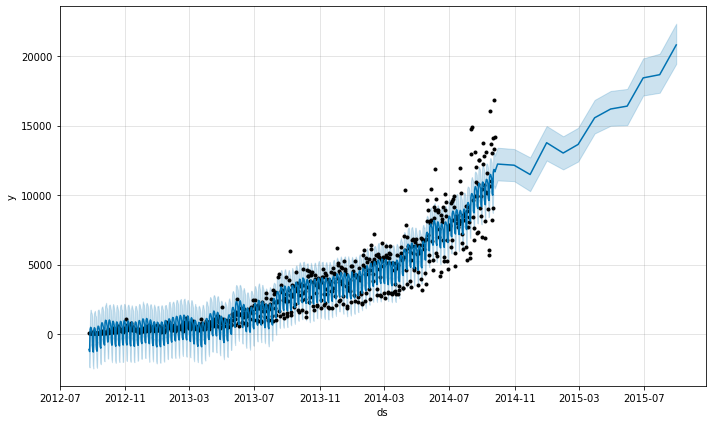

In [124]:
# 对节假日建模
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
#lower_window  -1包括制定日期之前的日期
#lower_window  0包括制定日期之后的日期
Chinese_season = pd.DataFrame({
  'holiday': 'Chinese season',
  'ds': pd.to_datetime(['2012-01-01', '2012-10-01', 
                        '2013-01-01', '2013-10-01',
                        '2014-01-01', '2014-10-01',
                        '2015-01-01', '2015-10-01',
                       '2016-01-01', '2016-10-01',
                        '2017-01-01', '2017-10-01']),
  'lower_window': -1,
  'upper_window': 0,
})
pro_holiday= Prophet(holidays=Chinese_season,daily_seasonality=True)
pro_holiday.fit(daily_train)
future_data = pro_holiday.make_future_dataframe(periods=12, freq = 'm')
 
#forecast the data for future data
forecast_data = pro_holiday.predict(future_data)
pro_holiday.plot(forecast_data);